# Machine Learning Model

In [2]:
import pandas as pd
import seaborn as sns
import xgboost as xgb
import joblib
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score

In [3]:
def pipeline(path):
  df = (pd
    .read_csv(path, parse_dates=['date'])
    .drop_duplicates()
    .dropna())

  df['sales_channel'] = df['sales_channel'].str.capitalize()
  df = df.drop(df.query('invested < 1 or returned < 1').index)

  df['year'] = df['date'].dt.year
  df['month'] = df['date'].dt.month
  df['day'] = df['date'].dt.day
  df['day_of_week'] = df['date'].dt.day_name()

  df = df.drop('date', axis=1)

  return df.reset_index(drop=True)

# pipeline semelhante a usada na parte de EDA, porém aqui nós quebramos
# a coluna da data em 3 colunas para dia, mes e ano para o modelo poder
# detectar suas diferenças de maneira mais eficiente

In [4]:
df = pipeline('../data.csv')
# importando o dataset para treinar o modelo de machine learning

In [5]:
df

,invested,returned,sales_channel,year,month,day,day_of_week
0,74025.0,108610.0,Print advertising,2020,1,1,Wednesday
1,33993.0,137278.0,Tv,2020,1,2,Thursday
2,92217.0,28635.0,Social media,2020,1,3,Friday
3,79190.0,34487.0,Radio,2020,1,4,Saturday
4,40134.0,43405.0,Social media,2020,1,5,Sunday
...,...,...,...,...,...,...,...
897,34306.0,14006.0,Tv,2022,12,27,Tuesday
898,42139.0,37726.0,Print advertising,2022,12,28,Wednesday
899,87553.0,47059.0,Radio,2022,12,29,Thursday
900,20543.0,13637.0,Tv,2022,12,30,Friday


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 902 entries, 0 to 901
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   invested       902 non-null    float64
 1   returned       902 non-null    float64
 2   sales_channel  902 non-null    object 
 3   year           902 non-null    int64  
 4   month          902 non-null    int64  
 5   day            902 non-null    int64  
 6   day_of_week    902 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 49.5+ KB


In [7]:
minMaxScaler_fit = [(feature, MinMaxScaler().fit(df[feature].values.reshape(-1,1))) for feature in ['invested', 'returned']]
# list comprehension para gerar um array contendo tuplas com nome da feature
# e o fit do MinMaxScaler nos valores da feature em si

joblib.dump(minMaxScaler_fit, '../minMaxScaler_fit.jbl')
# exportando o fit do MinMaxScaler de cada feature para usar posteriormente na dashboard do streamlit

for feature, scaler in minMaxScaler_fit:
  df[feature] = scaler.transform(df[feature].values.reshape(-1,1))
  # for loop para aplicar a transformação em todas as features necessárias

df.head()
# agora os valores destas features possuem um min de 0 e max de 1,
# porém a escala é a mesma dos dados originais. Dessa forma o modelo
# consiguirá ser mais eficiênte em seu treinamento

,invested,returned,sales_channel,year,month,day,day_of_week
0,0.675147,0.758737,Print advertising,2020,1,1,Wednesday
1,0.174434,0.979663,Tv,2020,1,2,Thursday
2,0.902689,0.142421,Social media,2020,1,3,Friday
3,0.739750,0.187519,Radio,2020,1,4,Saturday
4,0.251245,0.256244,Social media,2020,1,5,Sunday


In [8]:
labelEncoder_fit = [(feature, LabelEncoder().fit(df[feature])) for feature in df.select_dtypes('object').columns]
# semelhante ao que foi feito acima com o MinMaxScaler, aqui está sendo feito com o LabelEncoder

joblib.dump(labelEncoder_fit, '../labelEncoder_fit.jbl')
# exportando pelo mesmo motivo explicado anteriormente

for feature, fit in labelEncoder_fit:
  df[feature] = fit.transform(df[feature])

df.head()
# agora as features categóricas estão diferenciadas numericamente (0,1,2,...)
# isso é feito para que o modelo seja treinado corretamente, já que ele não é
# capaz de diferenciar strings, e sim números

,invested,returned,sales_channel,year,month,day,day_of_week
0,0.675147,0.758737,0,2020,1,1,6
1,0.174434,0.979663,3,2020,1,2,4
2,0.902689,0.142421,2,2020,1,3,0
3,0.739750,0.187519,1,2020,1,4,2
4,0.251245,0.256244,2,2020,1,5,3


In [9]:
df.describe()
# todas colunas agora são numéricas e podemos ver nas 2 primeiras colunas
# que o min e max estão 0 e 1 como foi dito anteriormente

,invested,returned,sales_channel,year,month,day,day_of_week
count,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000
mean,0.508875,0.502045,1.810421,2020.984479,6.527716,15.832594,2.990022
std,0.295612,0.291207,1.062206,0.825363,3.485630,8.843799,1.990240
min,0.000000,0.000000,0.000000,2020.000000,1.000000,1.000000,0.000000
25%,0.259415,0.253607,1.000000,2020.000000,3.000000,8.000000,1.000000
50%,0.498649,0.505391,2.000000,2021.000000,7.000000,16.000000,3.000000
75%,0.780269,0.753011,3.000000,2022.000000,10.000000,23.000000,5.000000
max,1.000000,1.000000,3.000000,2022.000000,12.000000,31.000000,6.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 902 entries, 0 to 901
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   invested       902 non-null    float64
 1   returned       902 non-null    float64
 2   sales_channel  902 non-null    int64  
 3   year           902 non-null    int64  
 4   month          902 non-null    int64  
 5   day            902 non-null    int64  
 6   day_of_week    902 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 49.5 KB


<AxesSubplot: >

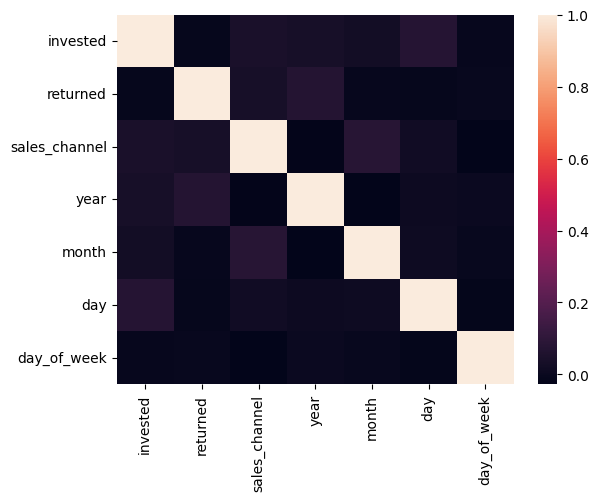

In [11]:
sns.heatmap(df.corr())
# observando a correlação entre as features para detectar a possível necessidade
# de remoção de alguma feature em caso de alta correlação com outra, porém aqui
# por se tratar de dados que foram gerados aleatóriamente, não detectamos correlação

In [12]:
pd.Series([vif(df.values, i) for i in range(len(df.columns))], index=df.columns)
# verificando o VIF (variance_inflation_factor) que demonstra o nível de multicolíneariede
# entre as features, e podemos perceber que a coluna do ano possui um alto valor e isso pode
# porejudicar a precisão do modelo a ser treinado

# eu cheguei a remover esta coluna para ver se a precisão do modelo melhorasse, mas na verdade
# piorou, então decidi mantê-lo normalmente

invested          3.998862
returned          3.982933
sales_channel     3.949376
year             17.761289
month             4.543491
day               4.235129
day_of_week       3.262723
dtype: float64

In [13]:
x = df.drop('returned', axis=1)
y = df['returned']
# separando as features preditivas da feature a ser prevista (target feature)

In [14]:
x

,invested,sales_channel,year,month,day,day_of_week
0,0.675147,0,2020,1,1,6
1,0.174434,3,2020,1,2,4
2,0.902689,2,2020,1,3,0
3,0.739750,1,2020,1,4,2
4,0.251245,2,2020,1,5,3
...,...,...,...,...,...,...
897,0.178349,3,2022,12,27,5
898,0.276323,0,2022,12,28,6
899,0.844353,1,2022,12,29,4
900,0.006204,3,2022,12,30,0


In [15]:
y

0      0.758737
1      0.979663
2      0.142421
3      0.187519
4      0.256244
         ...   
897    0.029685
898    0.212480
899    0.284403
900    0.026841
901    0.101855
Name: returned, Length: 902, dtype: float64

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=7)
# realizando o split entre os dados para treino e teste

In [17]:
print(f'x_train = {x_train.shape} | y_train = {y_train.shape} | x_test = {x_test.shape} | y_test = {y_test.shape}')
# observando o tamanho de cada set (linhas, colunas)

x_train = (721, 6) | y_train = (721,) | x_test = (181, 6) | y_test = (181,)


In [18]:
model = xgb.XGBRegressor(eval_metric='rmsle')
# eu pessoalmente gosto dos modelos do LGBM, mas neste projeto decidi usar o famoso
# XGBoost como seu modelo de regressão pois nunca usei-o previamente e queria testá-lo

> **OBS.:** A partir da próxima célula, eu estarei usando `minMaxScaler_fit[1][1].inverse_transform(value)` para retornar o valor previsto de retorno na escala anterior à aplicação do MinMaxScaler, caso contrário o *output* será na escala entre 0 e 1, o que dificultaria no entendimento do nível de precisão do modelo.

> **OBS2.:** Todas as métricas de avaliação de precisão do modelo usadas neste notebook se tratam do RMSE (root mean squared error =~ raiz do erro médio quadrado), onde quanto menor melhor, já que se trata do quão distante o valor previsto deve estar do valor real da nossa feature target (retorno monetário)

In [19]:
cross_scrore = cross_val_score(model, x_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()
# realizando um cross validation para obter uma métrica de precisão mais geral ao treinar e testar
# em 5 partes de todo o set de treino, devolvendo a métrica de RMSE

minMaxScaler_fit[1][1].inverse_transform([[cross_scrore]])
# transformando o valor na escala anterior do dataset

array([[-34763.95930141]])

In [20]:
cross_scrore
# exemplificando aqui como seria o output caso não revertesse a escala

-0.34615382891429236

In [21]:
model.fit(x_train, y_train)
# treinando o modelo com o set de treino x e y

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [22]:
y_predict = model.predict(x_test)
# usando o modelo treinado para prever os valores do set de teste

In [23]:
minMaxScaler_fit[1][1].inverse_transform([y_predict[:10]])
# observando os valores previstos

array([[ 85689.3947323 ,  87965.34208733,  98441.69962263,
         87304.17574549,  87468.51792383,  62766.99054578,
         77135.37197429, 109007.98592806,  52664.84250185,
         20483.74664667]])

In [24]:
minMaxScaler_fit[1][1].inverse_transform([y_test[:10].values])
# comparar os valores acima com os valores reais do set de teste

array([[ 99111., 129287.,  27170.,  12386.,  79806.,  48252., 127708.,
        126579.,  33369.,  57201.]])

In [25]:
rmse = metrics.mean_squared_error(y_test, y_predict, squared=False)

minMaxScaler_fit[1][1].inverse_transform([[rmse]])
# RMSE dos dados previstos comparados aos dados reais

array([[50369.22065216]])

In [26]:
rmse
# mais uma vez demonstrando o valor sem a transformação da escala

0.30991284612836545

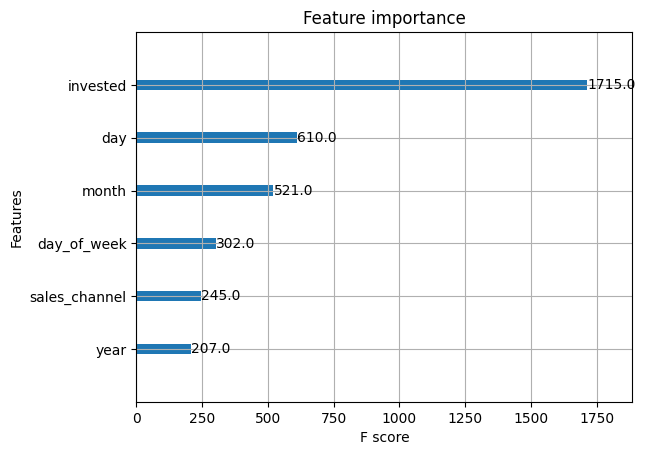

In [31]:
fig = xgb.plot_importance(model)
# observando as features que mais impactam na previsão no modelo

In [32]:
fig = fig.figure
fig.savefig('../feature-importance.png', dpi=300, bbox_inches='tight')
# salvando a imagem para apresentá-la na dashboard em produção

In [28]:
joblib.dump(model, '../model.jbl')
# exportando o modelo treinado para ser usado na produção (dashboard)

['../model.jbl']

> **PS.:** Neste projeto eu poderia ter realizado um *GridSearch* para obter os melhores hiperparâmetros do modelo escolhido, porém decidi não realizar já que se trata de um dataset fictício e com poucos registros, mas se fosse um projeto real e importante eu certamente utilizaria desta ferramenta.